# Head Velocity
Notebook for clean attempt of checking the distribution of head velocit and stimulus related behavior of the animal.

In [1]:
# data loading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats, integrate

%matplotlib inline
sns.set(color_codes=True)

path = '../datasets/'
dfrat     = pd.read_hdf(path+'relationalDatabase.h5', 'Rat_Behavior').set_index('index')
dfevent   = pd.read_hdf(path+'relationalDatabase.h5', 'Events').set_index('index')
dfsession = pd.read_hdf(path+'relationalDatabase.h5', 'Sessions').set_index('index')

## Angular velocity calculations
Calculating vectors, angle, velocity for comparison.

In [2]:
pd.options.mode.chained_assignment = None 

## SMOOTHING THE DATA
windowsize = 200
colChoice = ['X_Pos', 'Y_Pos', 'Z_Pos', 'X_Ori', 'Y_Ori', 'Z_Ori']

dfV = dfrat.copy()
g = dfV.groupby('session_id')
dfV[colChoice] = g[colChoice].rolling(window=windowsize).mean().values

dfV.dropna(inplace=True)


In [3]:
# ori_l = dfrat.melt(id_vars=['Frame', 'Time', 'session_id'], 
#            value_name='Orientation', value_vars=['X_Ori', 'Y_Ori', 'Z_Ori'], var_name='Dimension')


# ori_lSM = dfV.melt(id_vars=['Frame', 'Time', 'session_id'], 
#            value_name='Orientation', value_vars=['X_Ori', 'Y_Ori', 'Z_Ori'], var_name='Dimension')


In [4]:
## VECTORS WITHOUT Y
dfOri = pd.DataFrame()

for name, dd in dfV.groupby('session_id'):
    print(name)
    dd['dT'] = dd['Time'].diff(1)
    
    # calculating lenghts of VecX and VecZ and creation of shifted vectors  #dd = dd.apply(decompose_vec_df, axis=1)
    dd['lVo'] = np.linalg.norm(np.array([dd.X_Ori, dd.Y_Ori, dd.Z_Ori])  )
    dd['lx1'] = dd['X_Ori'] / dd['lVo']
    dd['lz1'] = dd['Z_Ori'] / dd['lVo']
    
    # normalize the data to unit vector form
    dd['V1'] = np.linalg.norm(np.array([dd.lx1, 0, dd.lz1]))
    dd['lx1'] = dd.lx1 / dd.V1
    dd['lz1'] = dd.lz1 / dd.V1

    dfOri = pd.concat([dfOri, dd], axis=0, ignore_index=True)

dfOri = dfOri.replace([np.inf, -np.inf], np.nan).dropna()
# print(dfOri)

0
1
2
3
4
5
6
7


In [5]:
## ANGLES and VELOCITY
dfOri2 = pd.DataFrame()

# calculatinig the angles between X axis and the vectors
for name, dd in dfOri.groupby('session_id'):
    print(name)
    
    V1 = np.array([dd.lx1, 0, dd.lz1])
    V2 = np.array([1     , 0, 0     ])
    
#     dd['theta0'] = np.arccos(dd.lx1*1 + dd.lz1*0 / (np.linalg.norm(V1) * np.linalg.norm(V2)))
    dd['theta0'] = np.arccos(dd.lx1 / (np.linalg.norm(V1) * np.linalg.norm(V2)))
    
    dd['theta1'] = dd.theta0.shift(1)
    dd['theta']  = dd.theta0 - dd.theta1
    dd.drop({'theta0','theta1'}, axis=1, inplace=True)
    
    # angular velocity between two vectors
    dd['U'] = np.degrees(dd.theta)/ dd.dT
    dd['UM'] = dd['U'].rolling(window=200).mean()
    dd['UMK'] = dd['U'].rolling(window=800).mean()
    
    dfOri2 = pd.concat([dfOri2, dd], axis=0, ignore_index=True)
    
dfOri2 = dfOri2.replace([np.inf, -np.inf], np.nan).dropna()
dfOri2 = dfOri2[np.absolute(dfOri2['dT'])<0.005]

# print(len(dfOri2[np.absolute(dfOri2['dT'])>0.005]))
# print(dfOri2.dT)


0
1
2
3
4
5
6
7


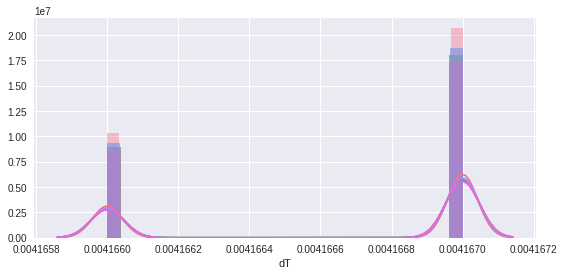

In [6]:
g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'dT');

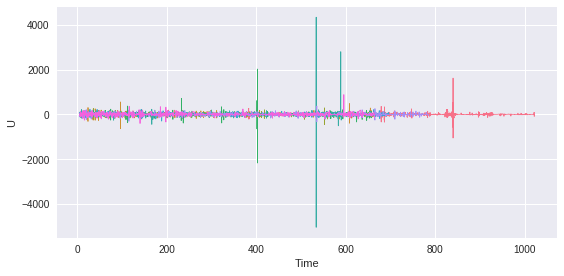

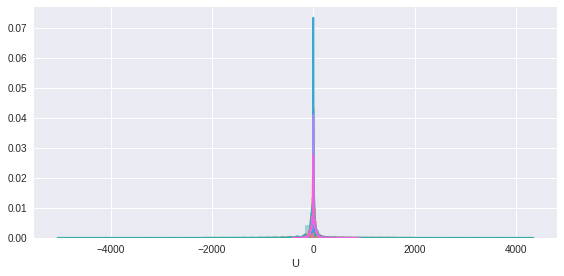

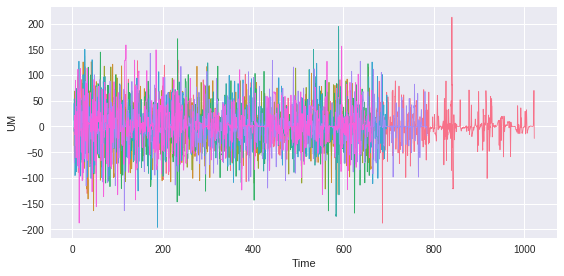

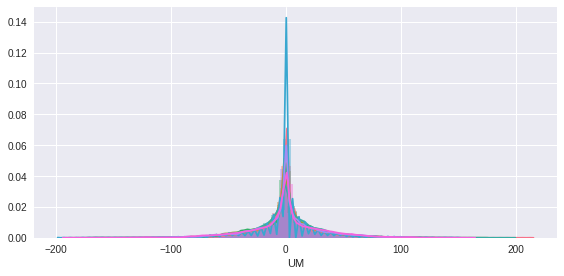

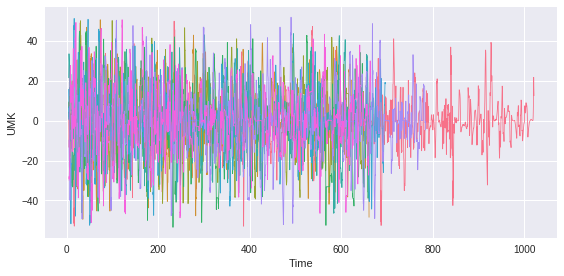

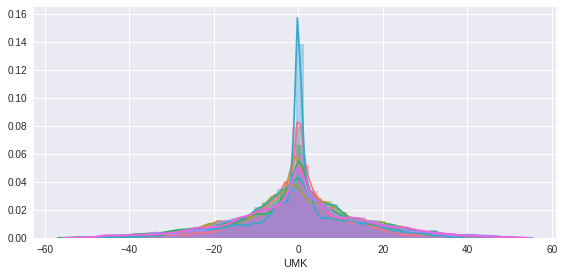

In [7]:
## ANGULAR VELOCITY IN Y AXIS

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(plt.plot, "Time", "U", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'U');

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(plt.plot, "Time", "UM", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'UM');

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(plt.plot, "Time", "UMK", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'UMK');


# dfOri2[np.absolute(dfOri2['U']) > 100]


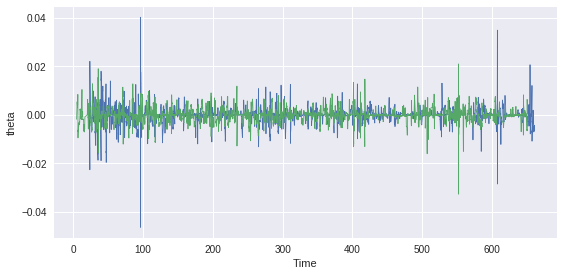

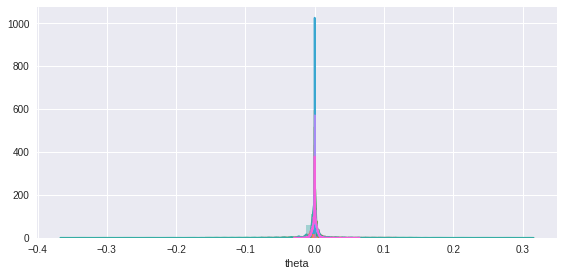

In [8]:
## THETHA CHANGE IN Y AXIS

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2, hue_order=[1,2])
g.map(plt.plot, "Time", "theta", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfOri2, size=4, aspect=2)#, hue_order=[1,2])
g.map(sns.distplot, 'theta');


## Stimulus-related behavior
Looking for frames detected as SRB.

SRB = {f E FRAMES: ||Vhead - Vstim|| < Dmax}

In [9]:
# ## COMPARISON WITH EVENT DATA
# remove unused columns
dfOri3 = dfOri2.drop({'lx1', 'lz1', 'V1', 'lVo', 'X_Pos', 'Y_Pos', 'Z_Pos', 'theta'}, axis=1)
dfeventsClean = dfevent.drop({'MotiveExpTimeSecs'}, axis=1)

dfV = pd.merge(dfOri3, dfeventsClean, on=['Time', 'session_id','Frame'])

In [10]:
dfV['subUM']  = dfV['speed'] - dfV['UM'] 
dfV['subU']   = dfV['speed'] - dfV['U'] 
dfV['subUMK'] = dfV['speed'] - dfV['UMK'] 
    
dfV = dfV.replace([np.inf, -np.inf], np.nan).dropna()

In [11]:
dfV.head()

,Frame,Time,session_id,X_Ori,Y_Ori,Z_Ori,dT,U,UM,UMK,visible,speed,subUM,subU,subUMK
0,1000,4.166667,0,-0.931707,0.309527,0.162038,0.004167,-11.864402,-2.674854,3.884740,0,0.0,2.674854,11.864402,-3.884740
1,1001,4.170834,0,-0.931560,0.307960,0.162905,0.004167,-12.788650,-3.175338,3.915160,0,0.0,3.175338,12.788650,-3.915160
2,1002,4.175000,0,-0.931391,0.306283,0.163830,0.004166,-13.677896,-3.675894,3.943364,0,0.0,3.675894,13.677896,-3.943364
3,1003,4.179167,0,-0.931198,0.304483,0.164823,0.004167,-14.696732,-4.177965,3.971383,0,0.0,4.177965,14.696732,-3.971383
4,1004,4.183334,0,-0.930985,0.302545,0.165868,0.004167,-15.505850,-4.680813,3.997454,0,0.0,4.680813,15.505850,-3.997454


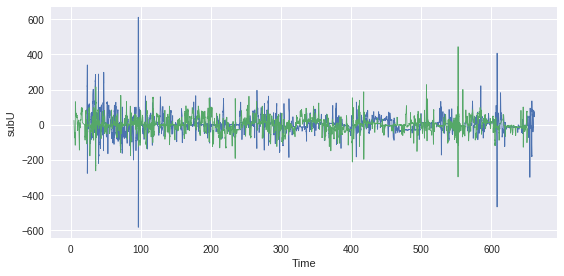

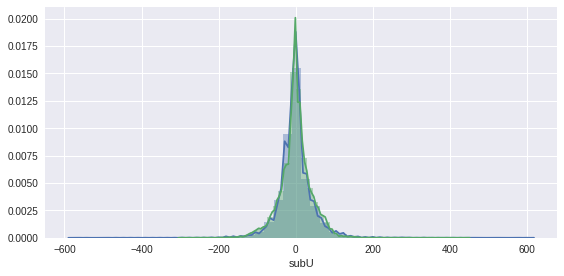

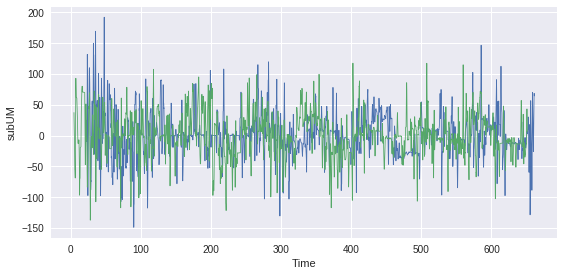

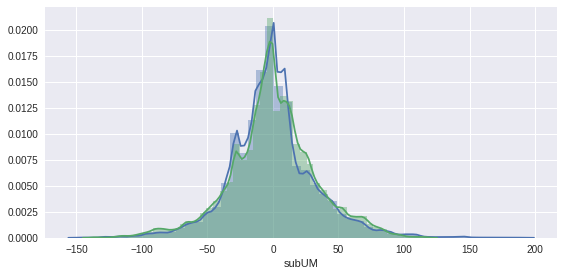

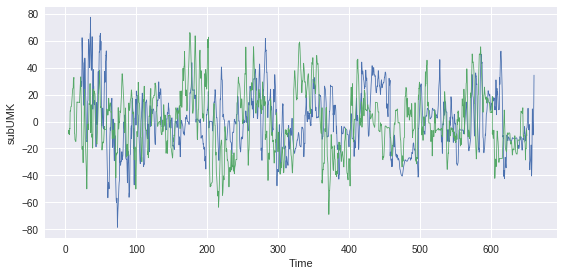

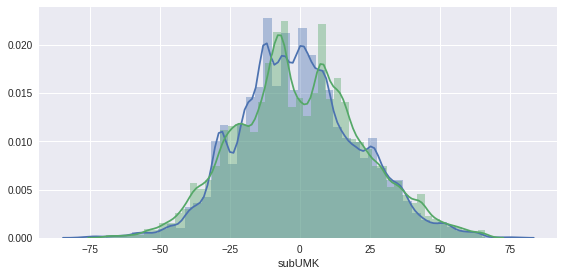

In [12]:
## ANGULAR VELOCITY IN Y AXIS

g = sns.FacetGrid(hue='session_id', data=dfV, size=4, aspect=2, hue_order=[1,2])
g.map(plt.plot, "Time", "subU", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfV, size=4, aspect=2, hue_order=[1,2])
g.map(sns.distplot, 'subU');

g = sns.FacetGrid(hue='session_id', data=dfV, size=4, aspect=2, hue_order=[1,2])
g.map(plt.plot, "Time", "subUM", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfV, size=4, aspect=2, hue_order=[1,2])
g.map(sns.distplot, 'subUM');

g = sns.FacetGrid(hue='session_id', data=dfV, size=4, aspect=2, hue_order=[1,2])
g.map(plt.plot, "Time", "subUMK", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfV, size=4, aspect=2, hue_order=[1,2])
g.map(sns.distplot, 'subUMK');



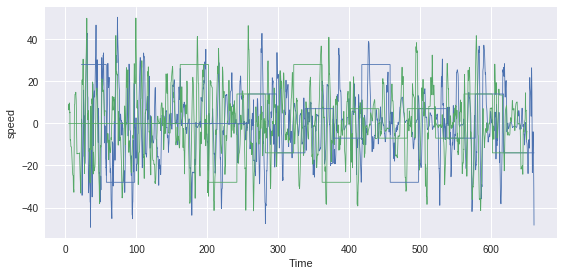

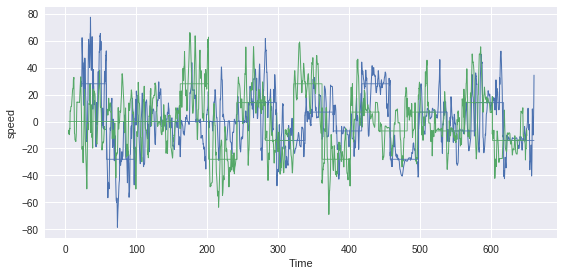

In [13]:
g = sns.FacetGrid(hue='session_id', data=dfV, size=4, aspect=2, hue_order=[1,2])
g.map(plt.plot, "Time", "UMK", alpha=1, linewidth=0.8);
g.map(plt.plot, "Time", "speed", alpha=1, linewidth=0.8);

g = sns.FacetGrid(hue='session_id', data=dfV, size=4, aspect=2, hue_order=[1,2])
g.map(plt.plot, "Time", "subUMK", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed", alpha=1, linewidth=0.8);

# g = sns.FacetGrid(hue='session_id', data=dfV, size=4, aspect=2, hue_order=[1,2])


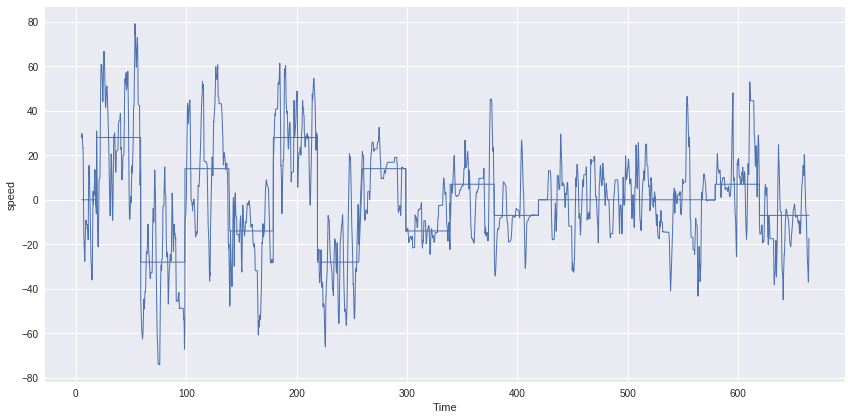

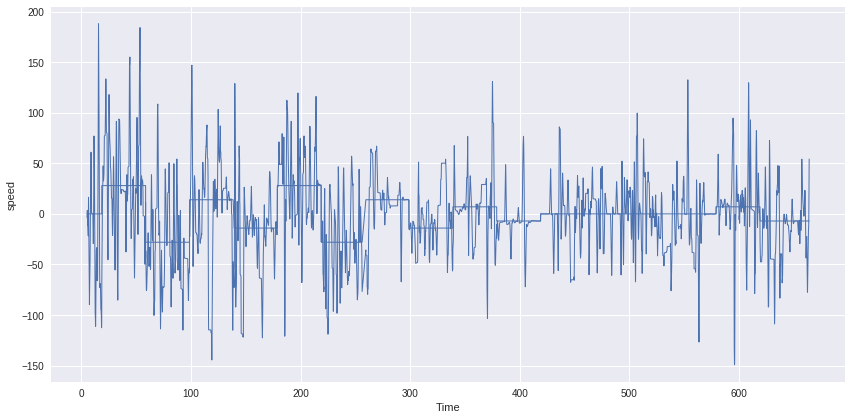

In [14]:
i = 7
g = sns.FacetGrid(data=dfV[dfV['session_id']==i], size=6, aspect=2)
g.map(plt.plot, "Time", "subUMK", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);

g = sns.FacetGrid(data=dfV[dfV['session_id']==i], size=6, aspect=2)
g.map(plt.plot, "Time", "subUM", alpha=1, linewidth=1);
g.map(plt.plot, "Time", "speed" , alpha=1, linewidth=1);


In [15]:
# setting Dmax as 20% of velocity at given moment // what about 0
DmaxPerc = 0.2
dfV['Dmax'] = dfV.speed * DmaxPerc
# dfV['Dmax'] = lambda dfV: 0.1 if dfV.Dmax == 0 else dfV.Dmax

dfV['SRB_UM']  = np.absolute(dfV['subUM'].values)  < np.absolute(dfV['Dmax'].values)
dfV['SRB_UMK'] = np.absolute(dfV['subUMK'].values) < np.absolute(dfV['Dmax'].values)

sumFrame = len(dfV.Frame)

# checking lenght of SRB frames in the filtered experiment data
SRB_UM = dfV[dfV['SRB_UM']]
SRB_UMK = dfV[dfV['SRB_UMK']]
sumSRB_UM = len(SRB_UM)
sumSRB_UMK = len(SRB_UMK)

print('stimulus-related behavior UM : %f%%' % (sumSRB_UM  * 100 / sumFrame))
print('stimulus-related behavior UMK: %f%%' % (sumSRB_UMK * 100 / sumFrame), '\n')


## SRB PER EXPERIMENT
sumFrameexp   = {}
sumSRBexp_UM  = {}
sumSRBexp_UMK = {}

for i, dd in dfV.groupby('session_id'):
    sumFrameexp[i] = len(dd.Frame)
    
    sumSRBexp_UM[i]  = len(dd[dd['SRB_UM']])
    sumSRBexp_UMK[i] = len(dd[dd['SRB_UMK']])
    
    print('stimulus-related behavior exp %d UM : %f%%'  % (i, sumSRBexp_UM[i]  * 100 / sumFrameexp[i]))
# %%!
print()
for i, dd in dfV.groupby('session_id'):    
    print('stimulus-related behavior exp %d UMK : %f%%' % (i, sumSRBexp_UMK[i] * 100 / sumFrameexp[i]))
    


stimulus-related behavior UM : 3.768316%
stimulus-related behavior UMK: 3.880643% 

stimulus-related behavior exp 0 UM : 2.930860%
stimulus-related behavior exp 1 UM : 3.492894%
stimulus-related behavior exp 2 UM : 5.145187%
stimulus-related behavior exp 3 UM : 3.919707%
stimulus-related behavior exp 4 UM : 4.010517%
stimulus-related behavior exp 5 UM : 3.156685%
stimulus-related behavior exp 6 UM : 4.173494%
stimulus-related behavior exp 7 UM : 3.828384%

stimulus-related behavior exp 0 UMK : 4.235221%
stimulus-related behavior exp 1 UMK : 3.611851%
stimulus-related behavior exp 2 UMK : 3.989458%
stimulus-related behavior exp 3 UMK : 4.173086%
stimulus-related behavior exp 4 UMK : 3.584481%
stimulus-related behavior exp 5 UMK : 2.817476%
stimulus-related behavior exp 6 UMK : 4.528807%
stimulus-related behavior exp 7 UMK : 3.897329%
